In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [5]:
# Load the dataset
df = pd.read_csv('microsoft_stock.csv', parse_dates=['Date'], index_col='Date')

# Check the first few rows
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.325000   137.825000   138.965000  3.431962e+07
max     245.030000   246.130000   242.920000   244.990000  1.352271e+08
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


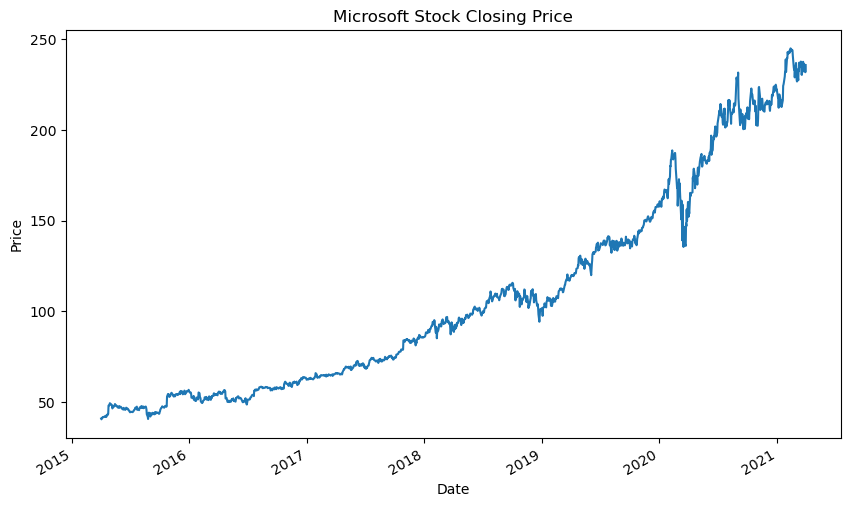

In [7]:
# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Plot the closing price to visualize the trend
df['Close'].plot(figsize=(10, 6), title="Microsoft Stock Closing Price", ylabel="Price")
plt.show()


In [11]:
# Use forward fill without the fillna method parameter
df.ffill(inplace=True)


In [13]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()

# Drop rows with NaN values (from lagging)
df.dropna(inplace=True)


In [15]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train[['lag_1', 'lag_2', 'rolling_mean_10']]
y_train = train['Close']
X_test = test[['lag_1', 'lag_2', 'rolling_mean_10']]
y_test = test['Close']


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users

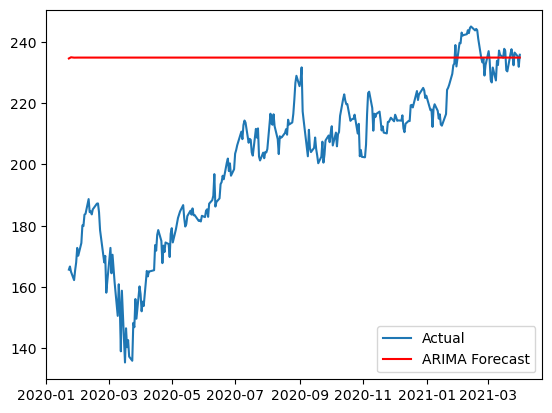

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model (e.g., (5, 1, 0) for p, d, q)
arima_model = ARIMA(df['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast the next values
arima_forecast = arima_result.forecast(steps=len(test))

# Plot the results
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
rf_pred = rf_model.predict(X_test)


In [48]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [50]:
from prophet import Prophet


In [58]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


20:20:43 - cmdstanpy - INFO - Chain [1] start processing
20:20:44 - cmdstanpy - INFO - Chain [1] done processing


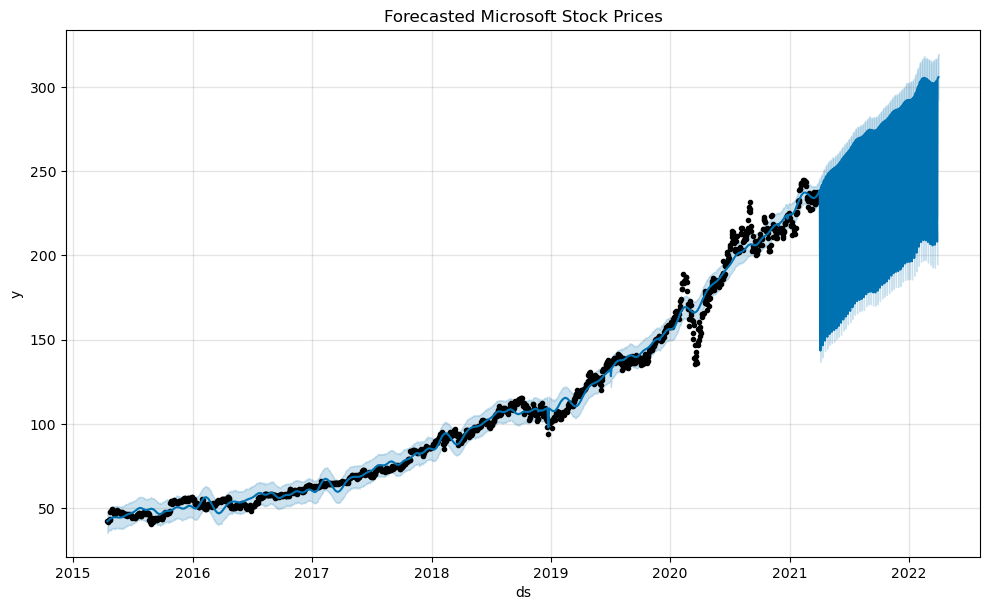

In [60]:
# Prepare data for Prophet
df_prophet = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Create a Prophet model instance
prophet_model = Prophet()

# Fit the model
prophet_model.fit(df_prophet)

# Make predictions for future dates
future_dates = prophet_model.make_future_dataframe(periods=365)  # Adjust the period as needed
forecast = prophet_model.predict(future_dates)

# Plot the forecast
prophet_model.plot(forecast)
plt.title("Forecasted Microsoft Stock Prices")
plt.show()


20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 60.653159873704176


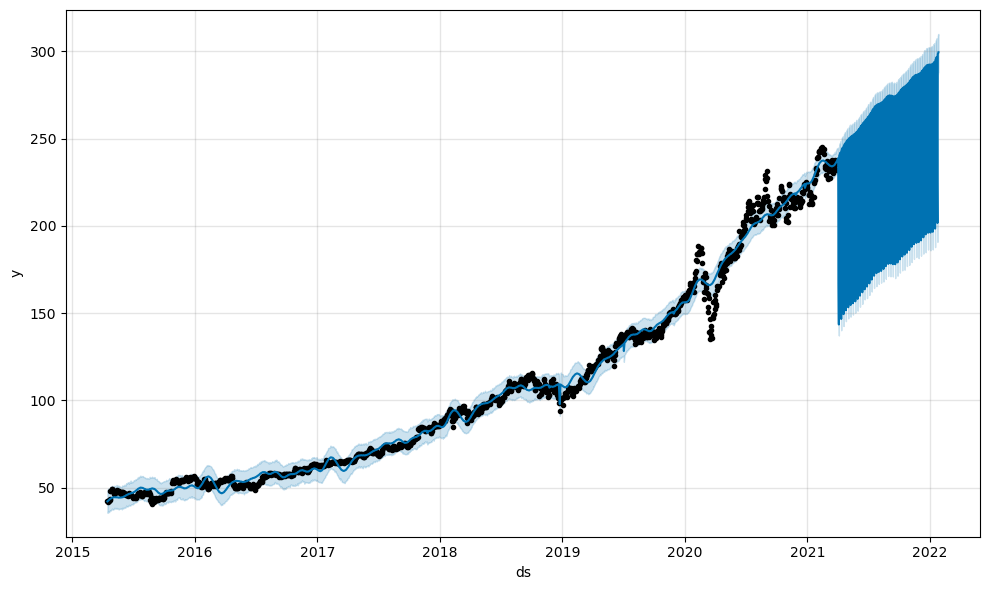

In [66]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Step 1: Prepare the data for Prophet
df_prophet = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Step 2: Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Step 3: Make future predictions (for the same period as the test set)
future_dates = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_forecast = prophet_model.predict(future_dates)

# Step 4: Evaluate the model using RMSE
prophet_rmse = mean_squared_error(test['Close'], prophet_forecast['yhat'][-len(test):], squared=False)
print(f'Prophet RMSE: {prophet_rmse}')

# Step 5: Plot the results
prophet_model.plot(prophet_forecast)
plt.show()


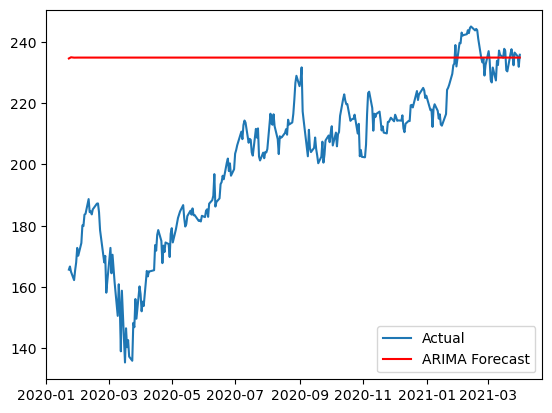

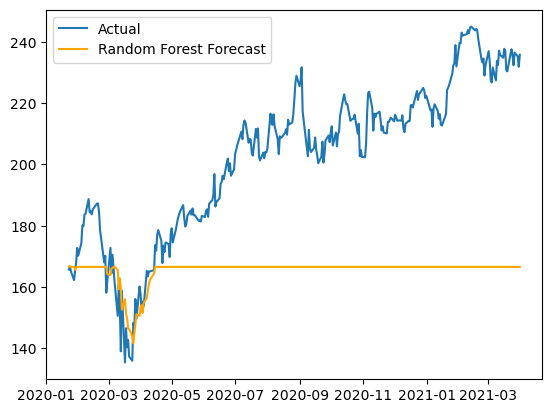

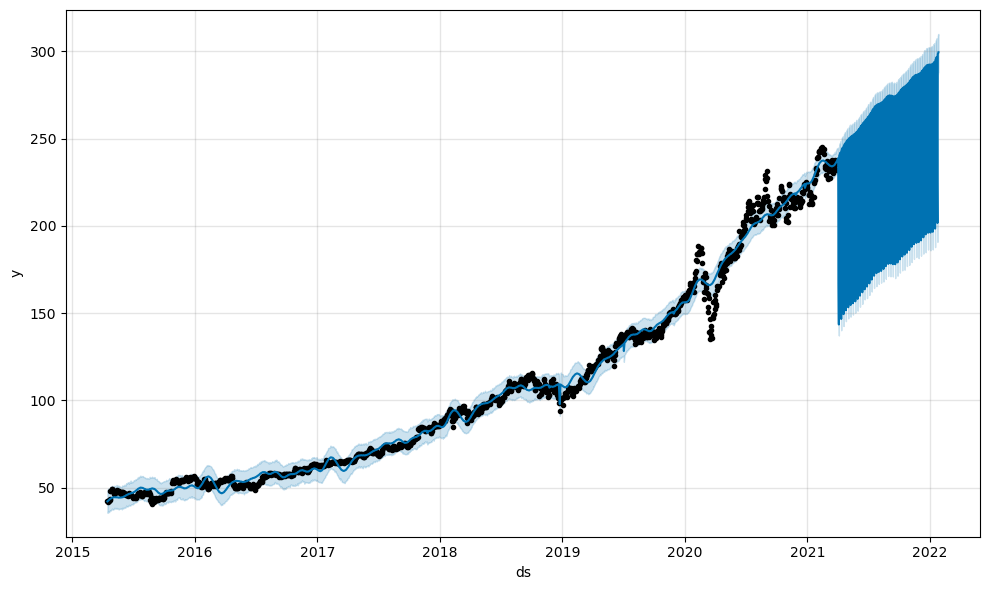

In [68]:
# Plot ARIMA vs actual values
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

# Plot Random Forest vs actual values
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, rf_pred, label='Random Forest Forecast', color='orange')
plt.legend()
plt.show()

# Prophet plot
prophet_model.plot(prophet_forecast)
plt.show()
